# Visualizing filters of a network trained to recognize metallicity from galaxy images
Here we're going to be following the [excellent blog post](https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030) by Fabio M. Graetz. Note that this code requires `torch` version 0.4 (even though technically `fastai` version 0.7 is incompatible)...

For `fastai` version 1.0, we may eventually want to look at something like [this deep dream example](https://github.com/kheyer/ML-DL-Projects/blob/master/Pytorch%20Deep%20Dream/dreaming.ipynb).

## Imports

In [19]:
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *

PATH = os.path.abspath('..')
sys.path.append(f'/home/john/projects/convnet-demo/src')
from multiclass import *

import requests

print(torch.__version__)

0.4.1


## Create `FilterVisualizer`

In [8]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output, requires_grad=True)
    def close(self):
        self.hook.remove()

In [9]:
class FilterVisualizer():
    def __init__(self, model, tfms, size=28, upscaling_steps=6, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = model.eval()
        self.tfms = tfms
        set_trainable(self.model, False)

    def visualize(self, layer, filter_idx, lr=0.1, opt_steps=20, wd=1e-6, blur=None):
        sz = self.size
        img = np.uint8(np.random.uniform(0, 50, (sz, sz, 3)))/255  # generate random image
        activations = SaveFeatures(list(self.model.children())[layer])

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            trn_tfms, val_tfms = tfms_from_model(model, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=wd)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter_idx].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter_idx)
        activations.close()
        
    def save(self, layer, filter_idx):
        plt.imsave(f'../results/layer_{layer}/filter_{filter_idx}.jpg', np.clip(self.output, 0, 1))

In [20]:
# rather than random image, begin with input im
def optimize_image(layer, filter_idx, input_image, sz=128):
    
    # downsize image to 128x128
    img = cv2.resize(np.array(input_image) / 255, (sz, sz), interpolation=cv2.INTER_CUBIC)

    activations = SaveFeatures(list(model.children())[layer])

    trn_tfms, val_tfms = tfms_from_model(model, sz)
    img_var = V(val_tfms(img)[None], requires_grad=True)

    optimizer = torch.optim.Adam([img_var], lr=1e-1, weight_decay=1e-6)
    for n in range(20):  
        optimizer.zero_grad()
        model(img_var)
        loss = -activations.features[0, filter_idx].mean()
        loss.backward()
        optimizer.step()

    optimizer = torch.optim.Adam([img_var], lr=1e-2, weight_decay=1e-6)
    for n in range(20):  
        optimizer.zero_grad()
        model(img_var)
        loss = -activations.features[0, filter_idx].mean()
        loss.backward()
        optimizer.step()

    optimized_img = val_tfms.denorm(img_var.data.numpy()[0].transpose(1,2,0))
    optimized_img = np.clip(optimized_img, 0, 1)
    activations.close()

    plt.figure(figsize=(7, 7))
    plt.imshow(optimized_img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

# ImageNet pretrained

**(or skip down to the [randomly initialized section](#Random-initialization-trained-model))**

## Load data and model

In [2]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n, val_pct=0.2, seed=256)

In [3]:
arch = resnet34
sz = 128
bs = 128

# get data transformers and ClassifierData object (for regression)
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

n_batch = len(data.trn_y) // bs

# initialize pretrained network
learn = ConvLearner.pretrained(arch, data)
learn.crit = rmse

/home/john/anaconda3/envs/fastai-v0.7_torch-v0.4/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/john/anaconda3/envs/fastai-v0.7_torch-v0.4/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [4]:
learn.load('resnet34-single_sz128-bs128')
learn.crit = rmse

In [5]:
model = learn.model

In [6]:
fn = PATH + '/' + data.val_ds.fnames[0]
img = PIL.Image.open(fn); 

## Visualize filters

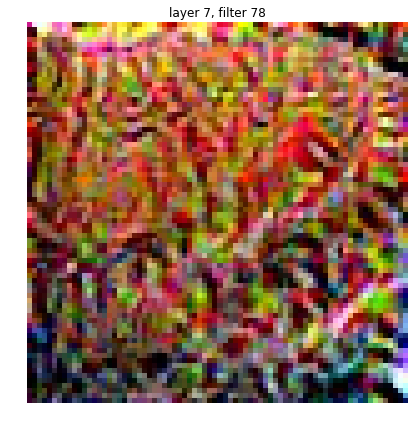

In [9]:
layer = 7
filter_idx = 78

FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=6, upscaling_factor=1.2)
FV.visualize(layer, filter_idx, lr=0.1, opt_steps=20, blur=None)

img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
plt.figure(figsize=(7,7))
plt.imshow(img)
plt.axis('off')
plt.title(f'layer {layer}, filter {filter_idx}');

## Take a look around

In [10]:
model[7][2].conv2

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Maybe let's just try a bunch of these...

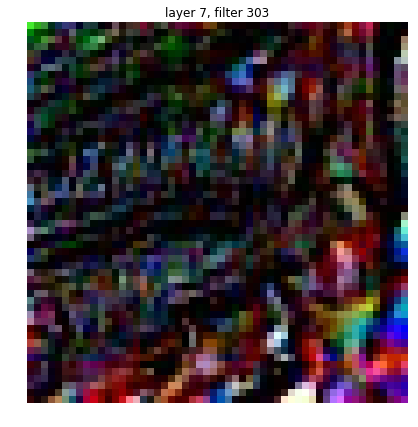

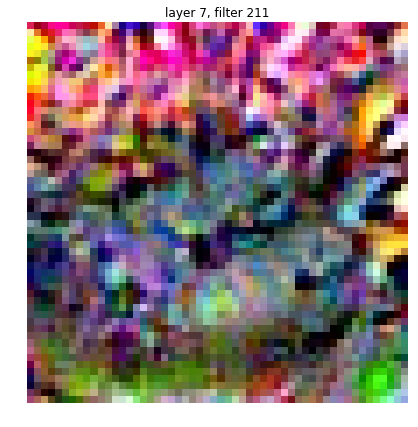

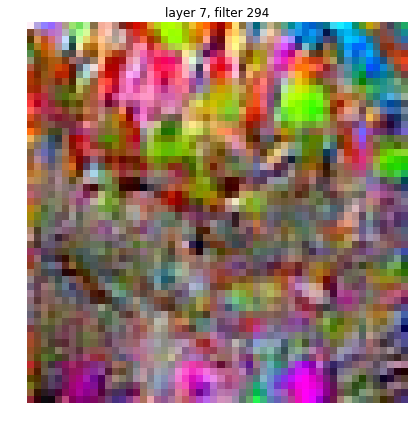

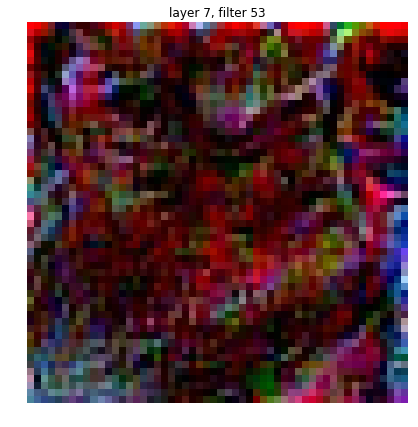

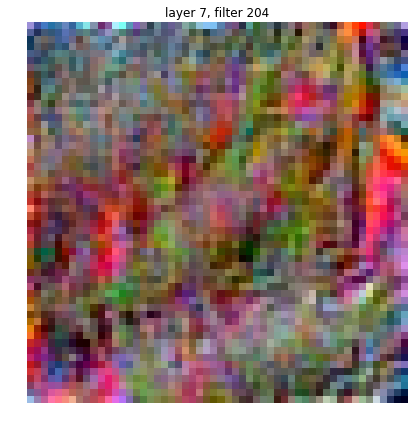

In [14]:
layer = 7

np.random.seed(1234)
for filter_idx in np.random.randint(512, size=5):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=4, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

## Targeted search?

Maybe we need to rethink our strategy. It makes sense to first look at the filters that have highest activations from a typical image.

In [15]:
x,y = next(iter(data.val_dl))

In [16]:
layer = 7
layer_7_model = nn.Sequential(*children(model)[:layer+1])
layer_7_activations = layer_7_model(x)

In [17]:
layer_7_activations.shape

torch.Size([80, 512, 4, 4])

In [18]:
top_10_filters = list(reversed(layer_7_activations.numpy().mean(axis=(0,2,3)).argsort()))[:10]
top_10_filters

[78, 90, 398, 221, 417, 494, 20, 379, 146, 438]

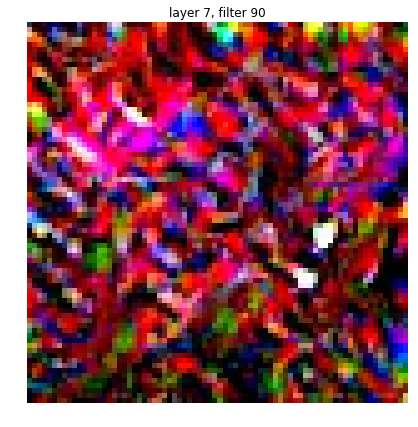

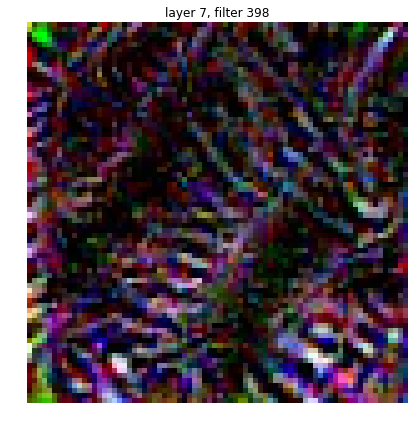

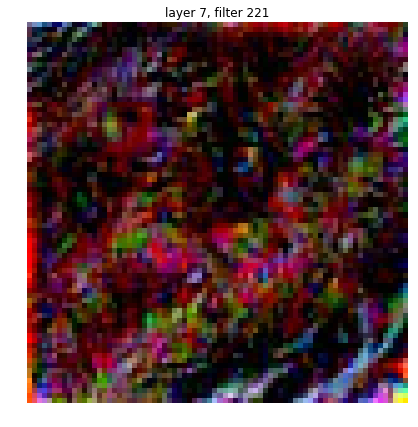

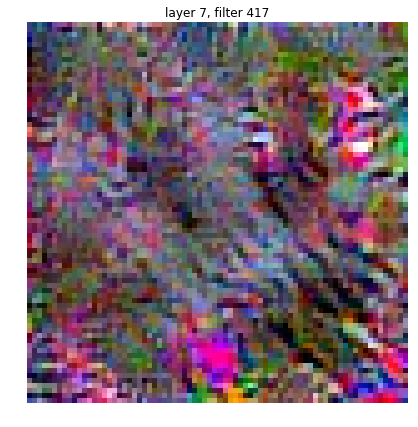

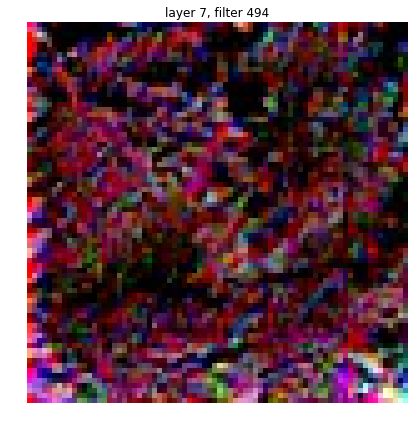

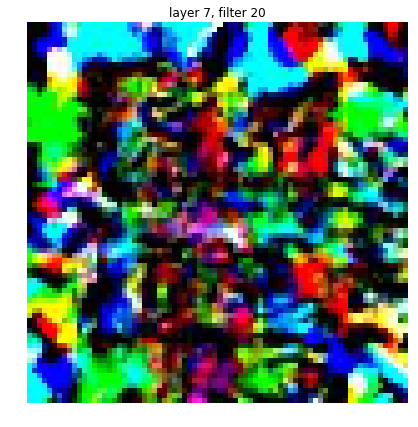

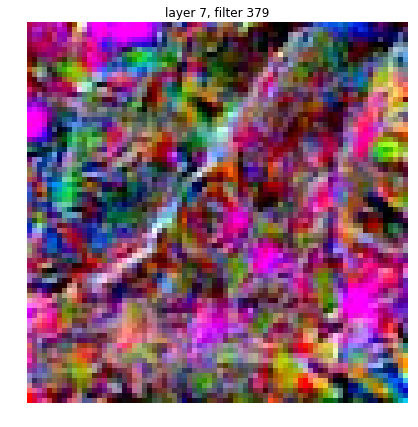

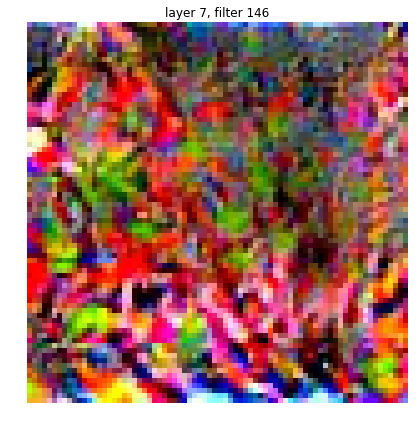

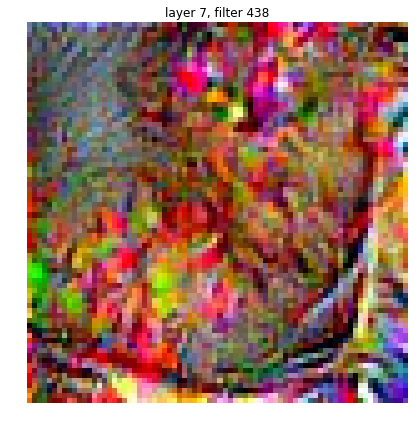

In [19]:
layer = 7

for filter_idx in top_10_filters[1:]:
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=6, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

## Search earlier layers

### Layer 0

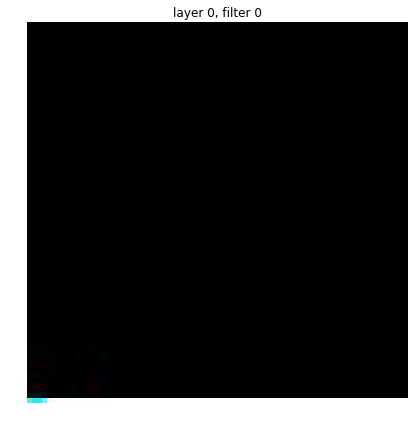

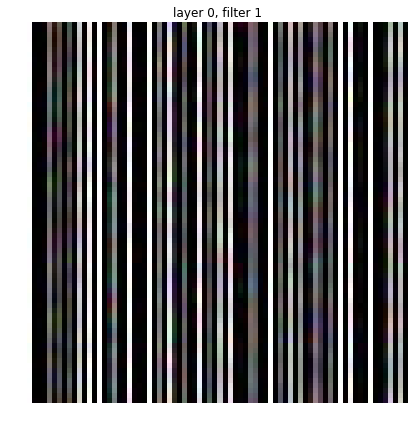

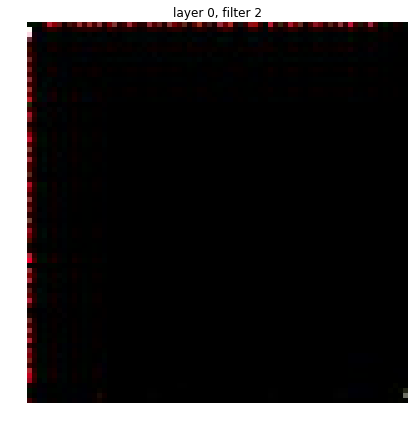

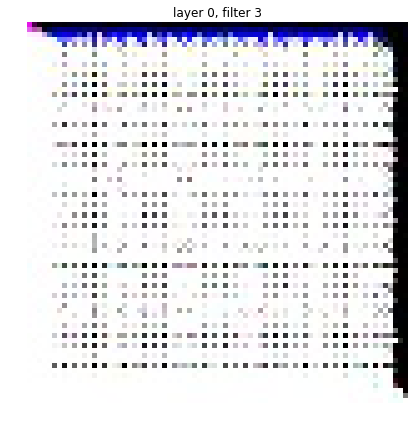

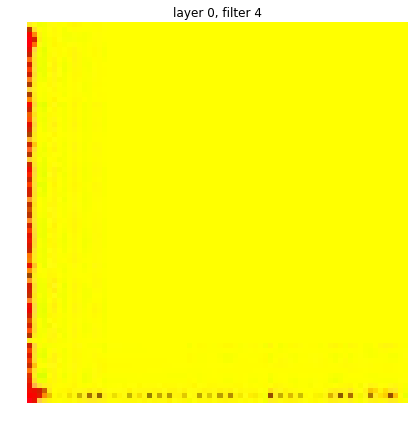

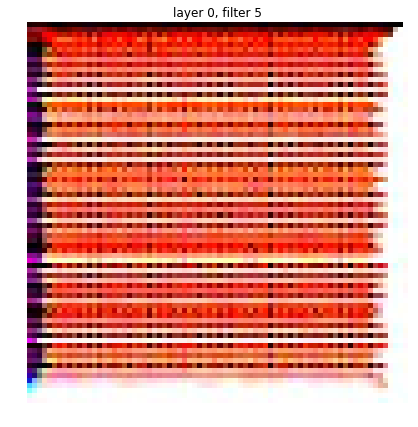

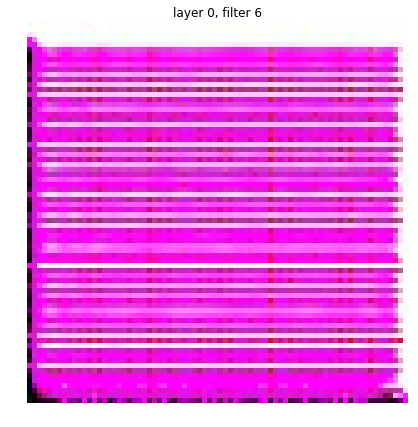

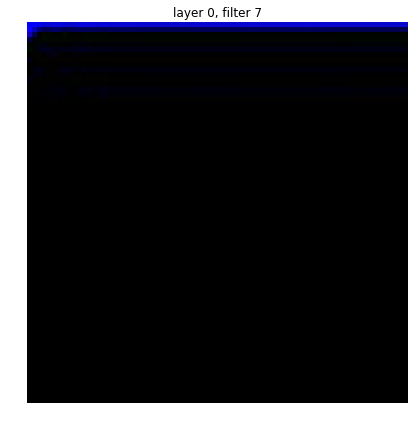

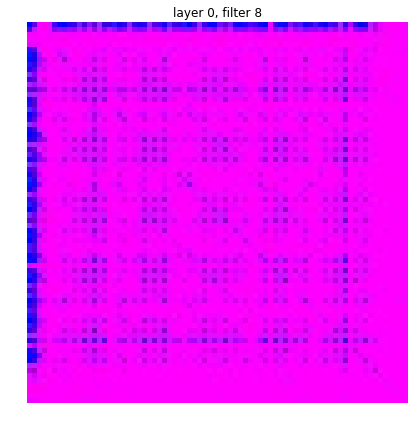

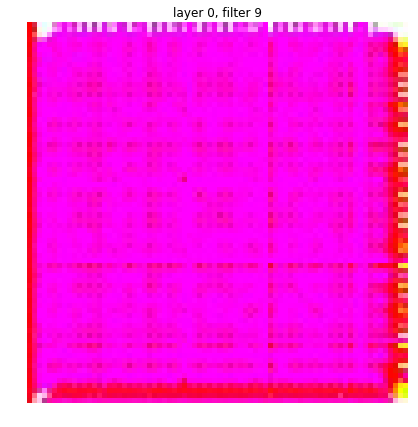

In [20]:
layer = 0

for filter_idx in range(0, 10):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=6, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, opt_steps=20, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

### Layer 4

In [21]:
list(model.children())[4]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

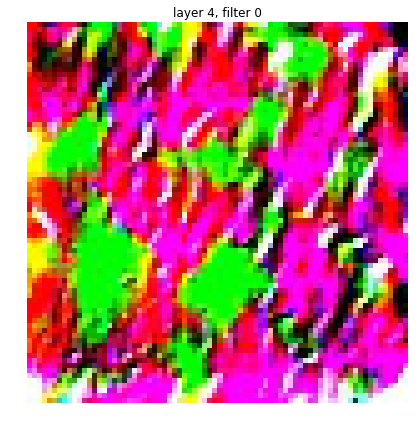

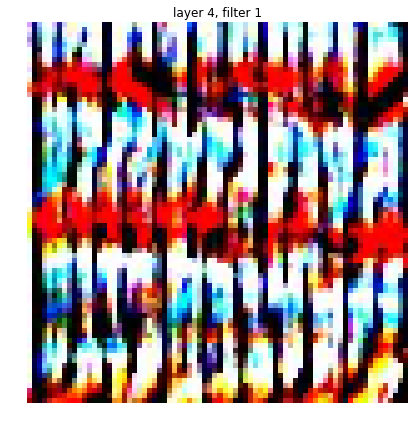

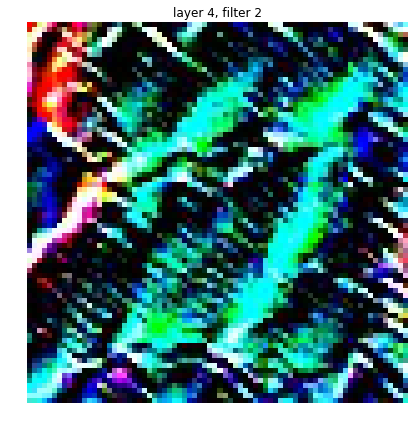

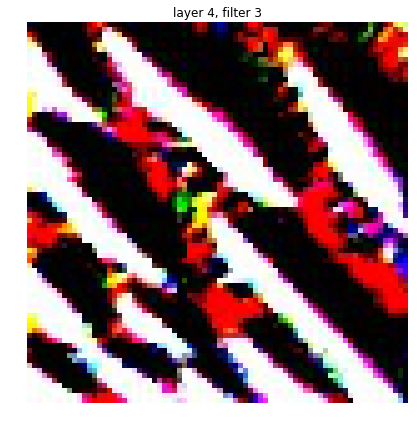

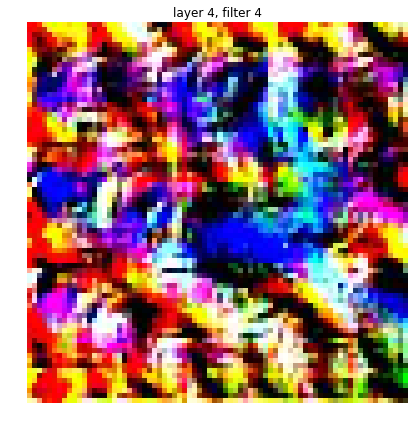

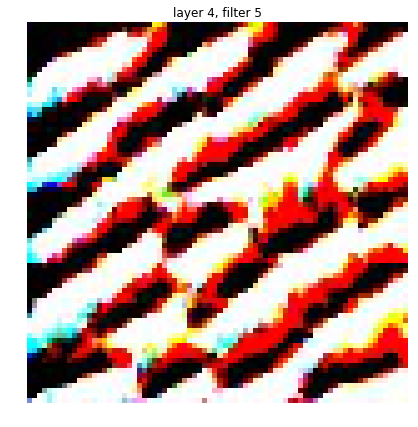

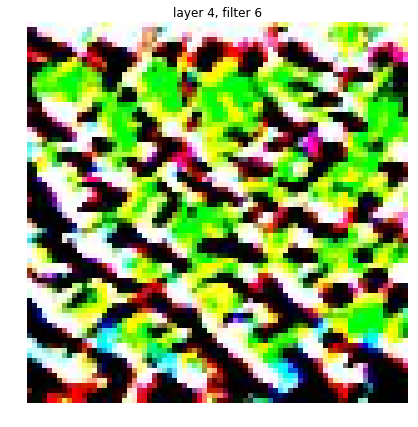

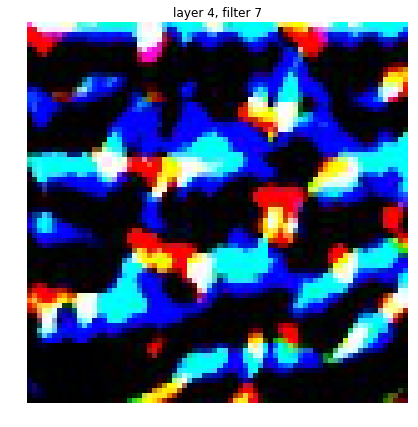

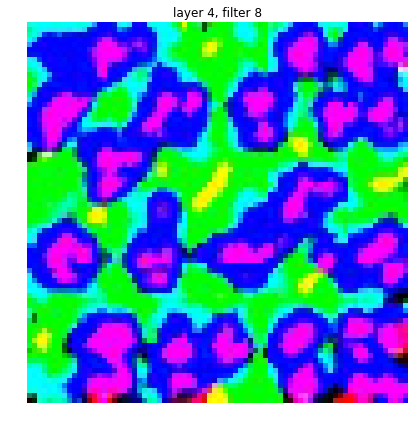

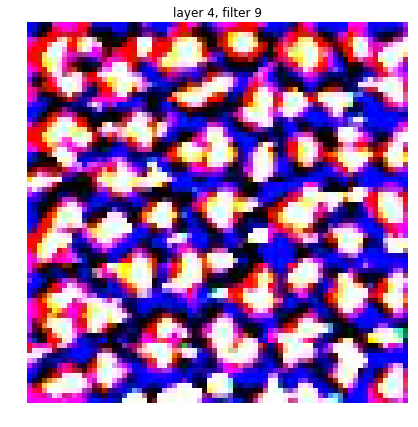

In [23]:
layer = 4

for filter_idx in range(0, 10):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=6, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, opt_steps=20, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

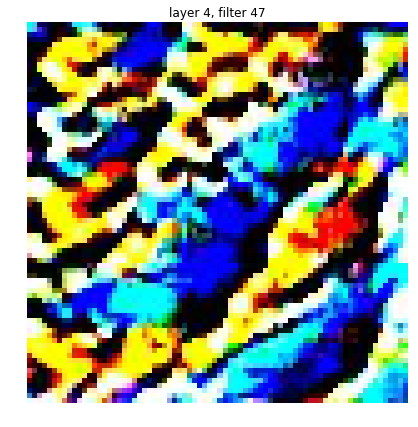

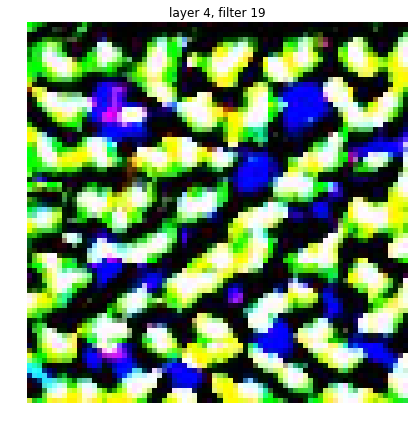

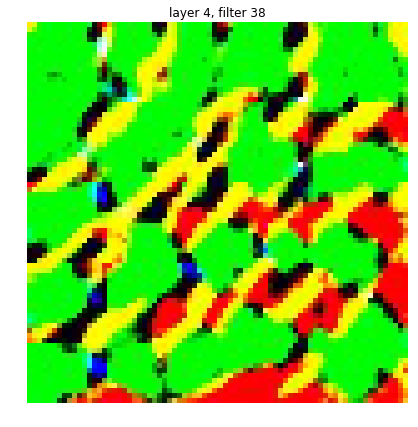

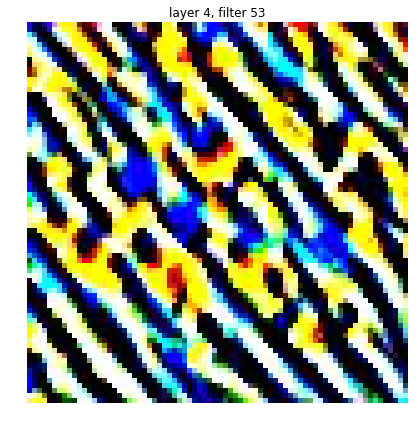

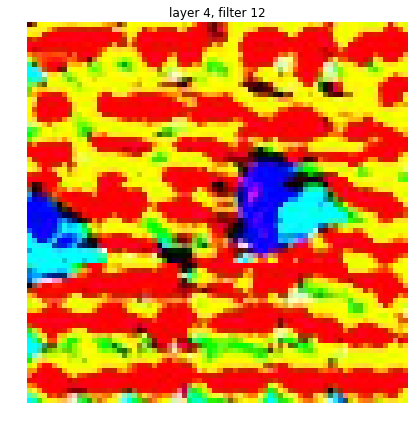

In [25]:
np.random.seed(1234)
for filter_idx in np.random.randint(64, size=5):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=6, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, opt_steps=20, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

### Layer 5

In [26]:
list(model.children())[5]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, moment

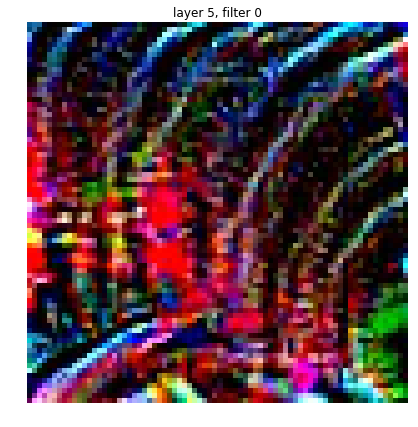

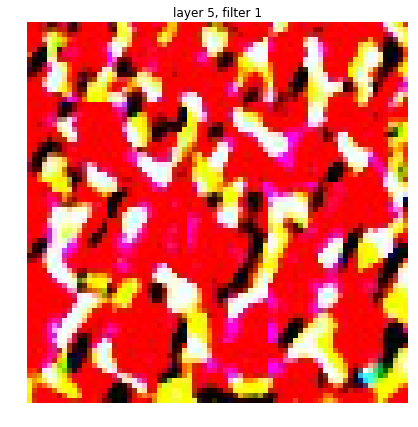

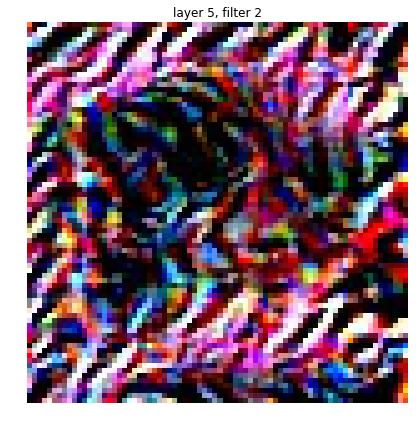

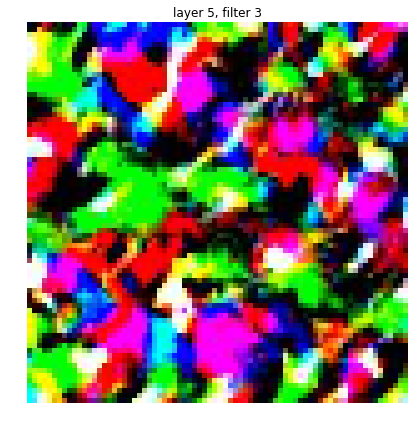

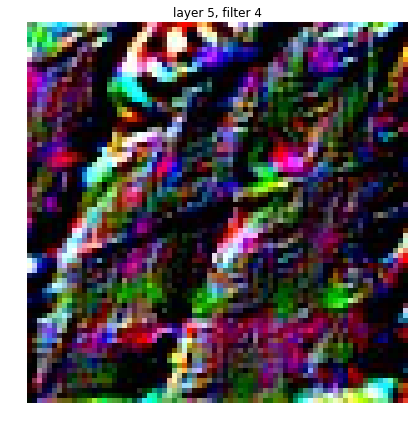

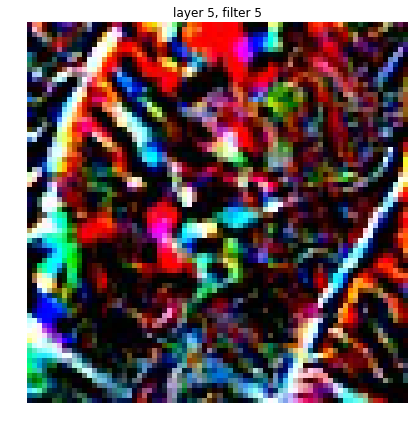

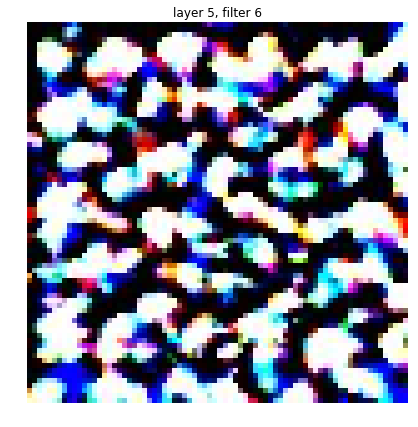

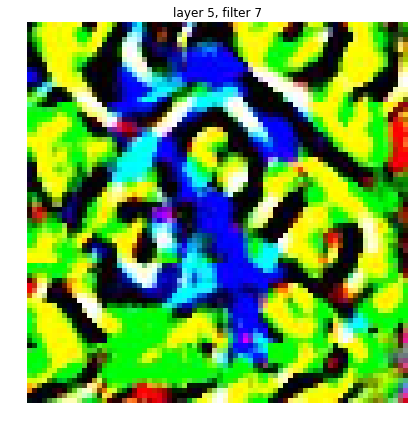

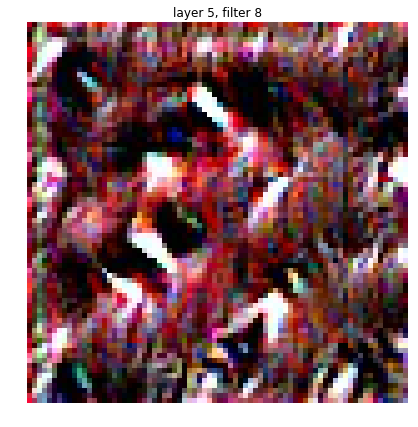

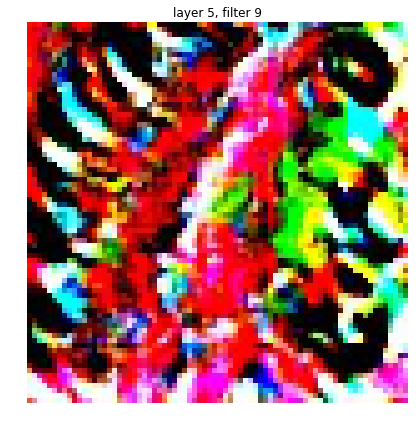

In [27]:
layer = 5

for filter_idx in range(0, 10):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=6, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, opt_steps=20, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

### Layer 6

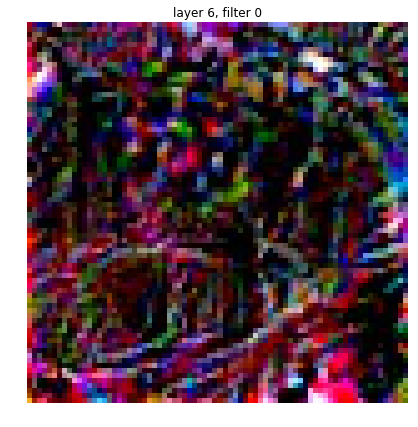

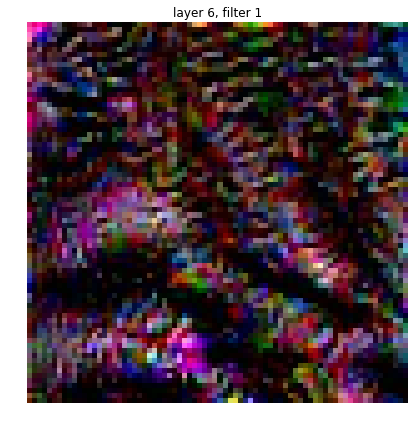

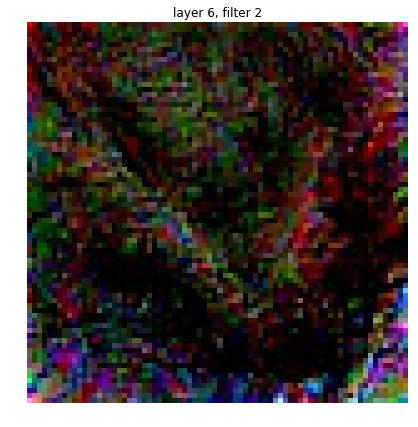

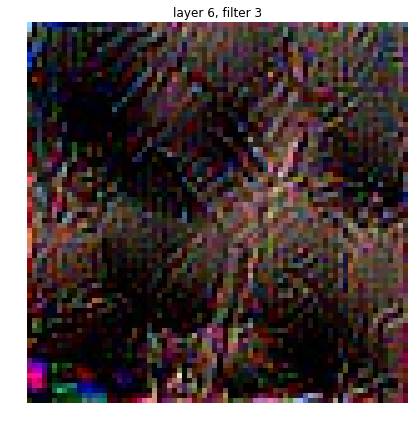

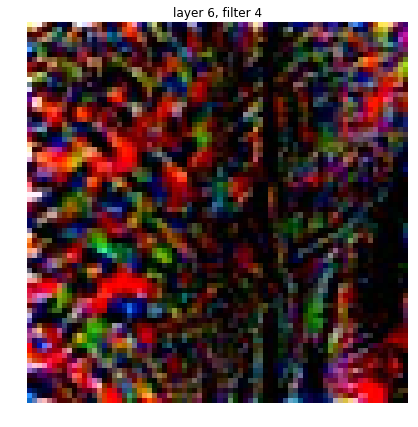

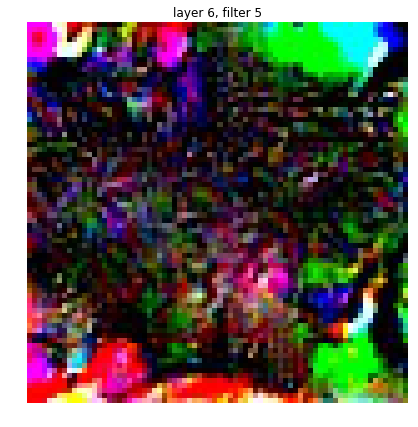

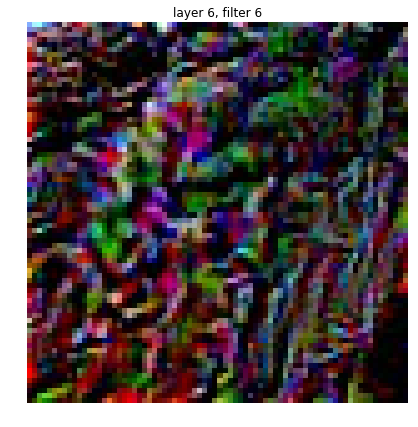

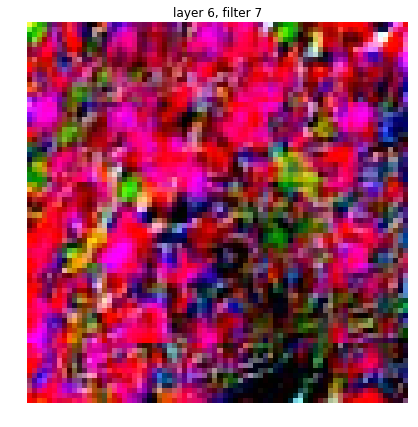

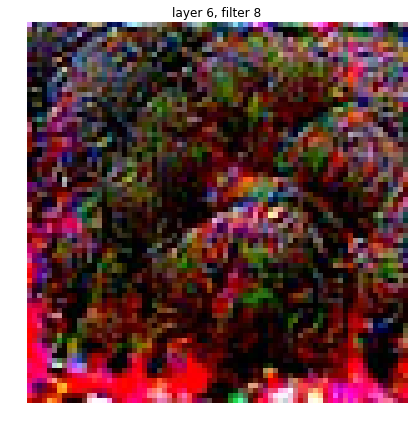

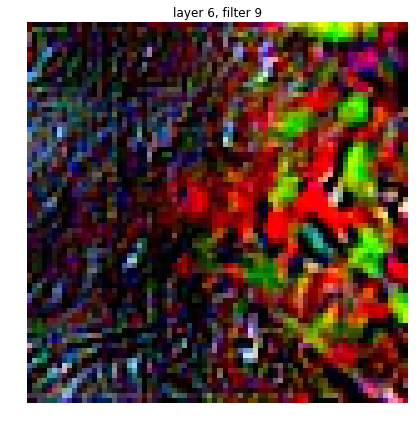

In [28]:
layer = 6

for filter_idx in range(0, 10):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=6, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, opt_steps=20, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

Layer 4 has very interesting and identifiable structure. Beyond that it just gets very messy...

## Visualizing features that trigger final linear layers

In [29]:
list(model.children())[12]

Linear(in_features=1024, out_features=512, bias=True)

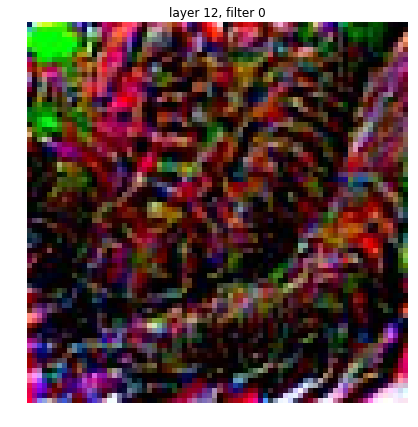

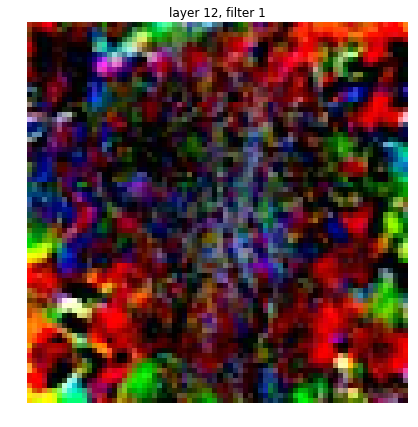

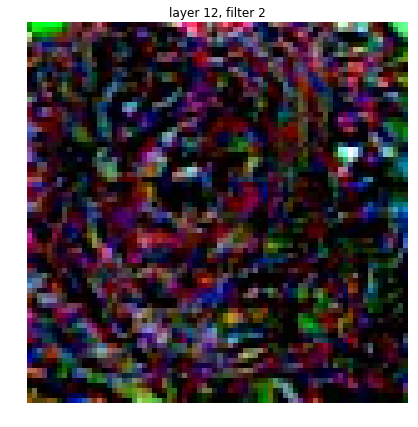

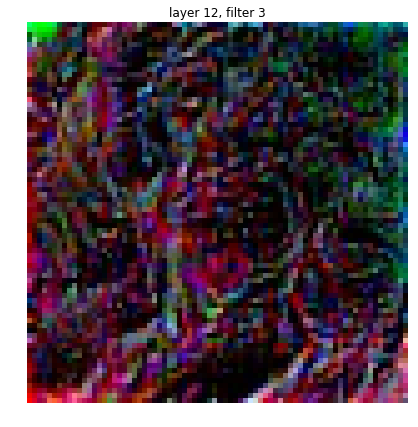

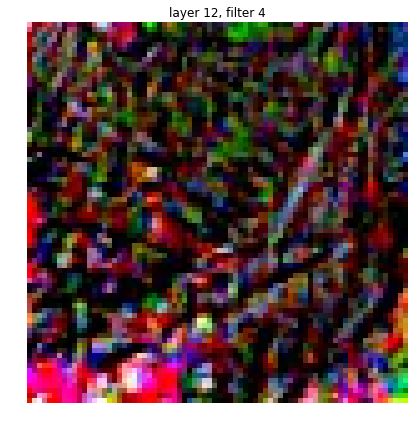

In [30]:
layer = 12

for filter_idx in range(0, 5):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=6, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, opt_steps=20, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

In [31]:
layer = 12
layer_12_model = nn.Sequential(*children(model)[:layer+1])
layer_12_activations = layer_12_model(x)

top_10_acts = list(reversed(layer_12_activations.numpy().mean(axis=(0)).argsort()))[:10]
top_10_acts

[391, 295, 441, 382, 243, 78, 187, 361, 281, 503]

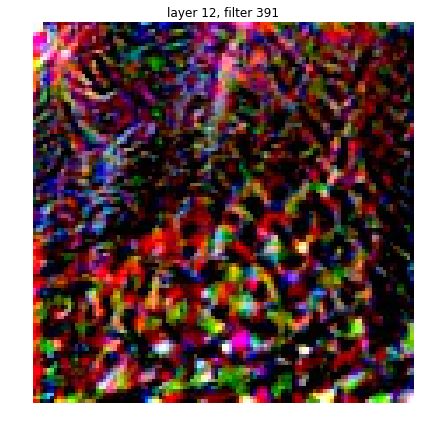

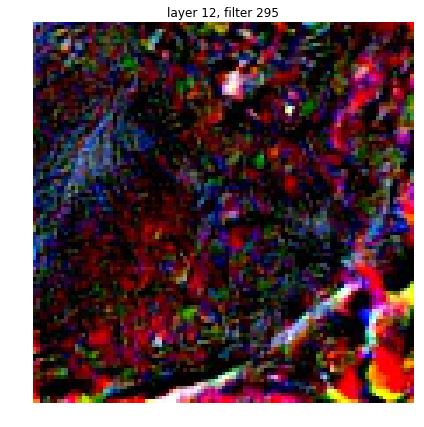

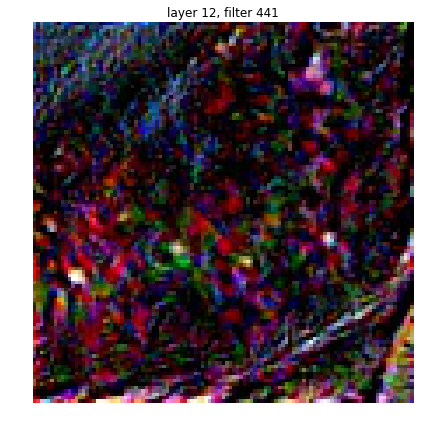

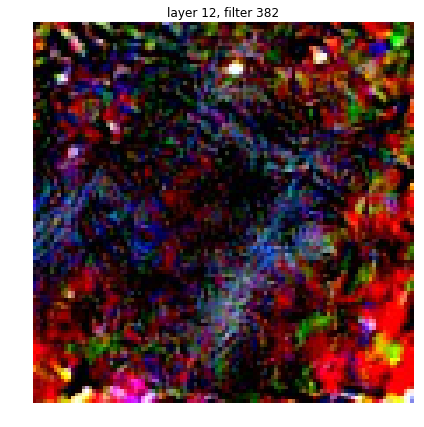

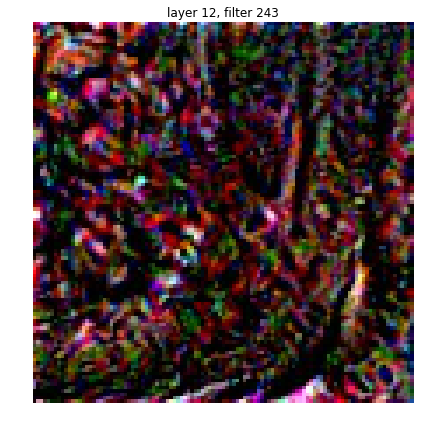

In [32]:
for filter_idx in top_10_acts[:5]:
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=8, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()


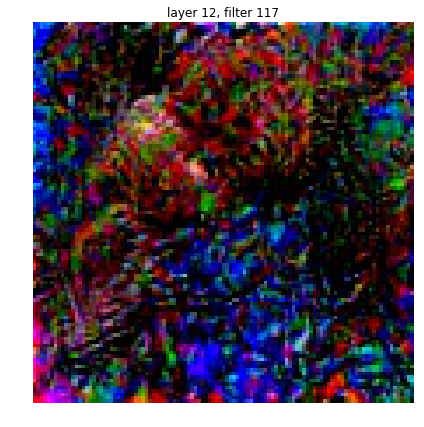

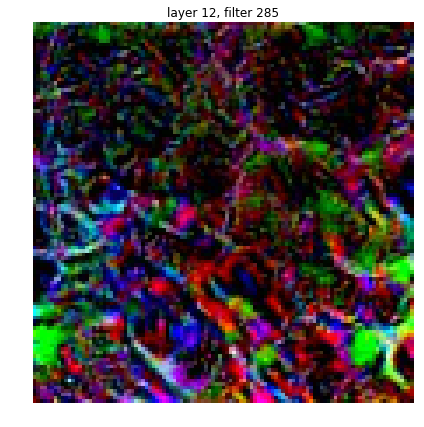

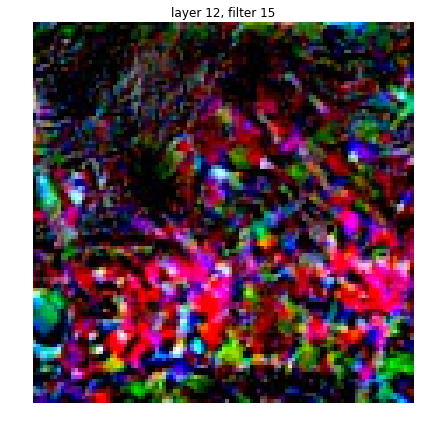

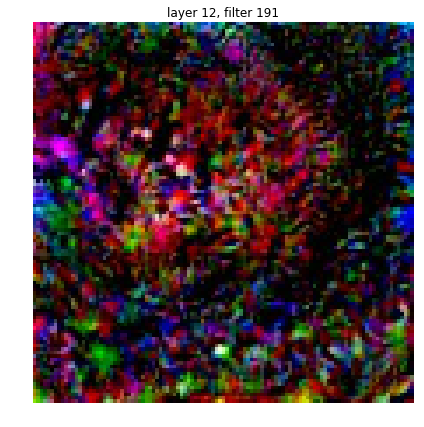

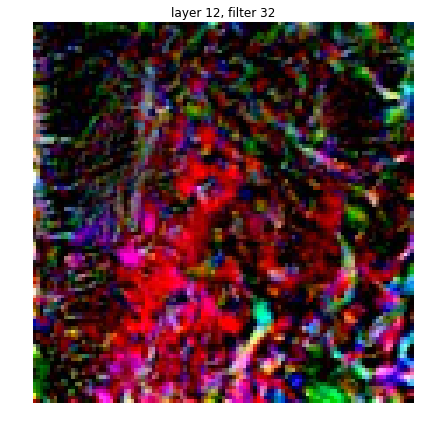

In [33]:
bottom_10_acts = list(layer_12_activations.numpy().mean(axis=(0)).argsort())[:10]

for filter_idx in bottom_10_acts[:5]:
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=8, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()


## Supply actual image: NGC 99

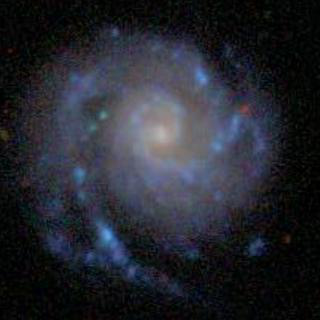

In [138]:
ngc99 = Image.open(requests.get('https://skyserver.sdss.org/dr13/en/tools/places/images/ngc99.jpg', stream=True).raw)
ngc99

### Layer 7

In [139]:
layer = 7
top_10_filters = list(reversed(layer_7_activations.numpy().mean(axis=(0,2,3)).argsort()))[:10]
top_10_filters

[78, 90, 398, 221, 417, 494, 20, 379, 146, 438]

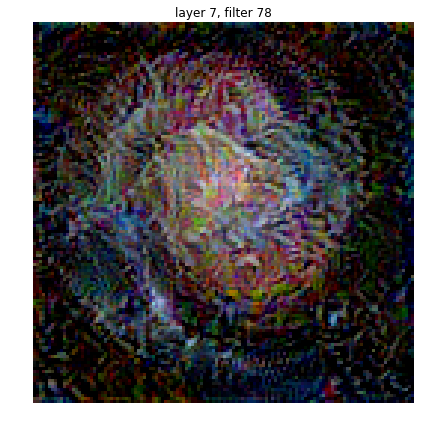

In [146]:
optimize_image(layer=7, filter_idx=78, input_image=ngc99)

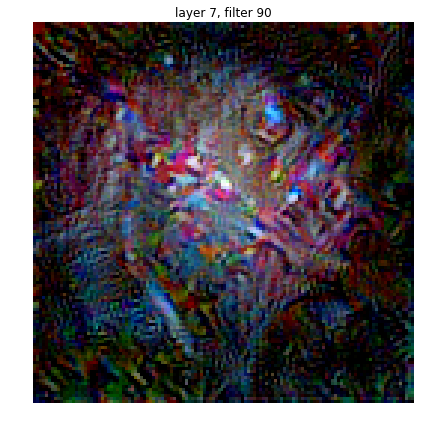

In [148]:
optimize_image(layer=7, filter_idx=90, input_image=ngc99)

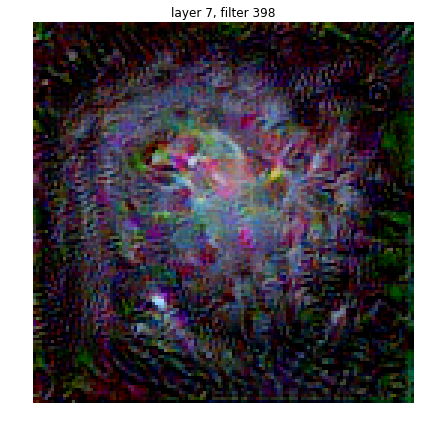

In [149]:
optimize_image(layer=7, filter_idx=398, input_image=ngc99)

### Layer 12

In [129]:
top_10_acts = list(reversed(layer_12_activations.numpy().mean(axis=(0)).argsort()))[:10]
top_10_acts

[391, 295, 441, 382, 243, 78, 187, 361, 281, 503]

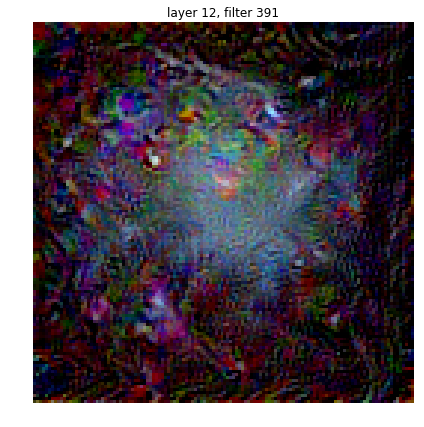

In [150]:
optimize_image(layer=12, filter_idx=391, input_image=ngc99)

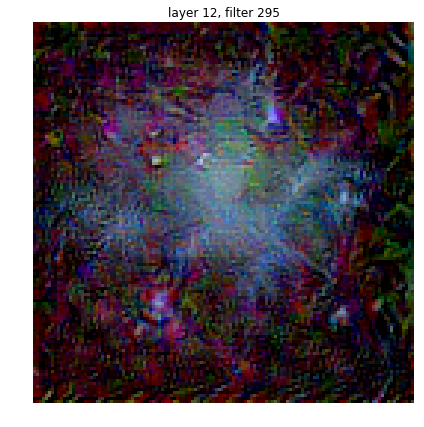

In [151]:
optimize_image(layer=12, filter_idx=295, input_image=ngc99)

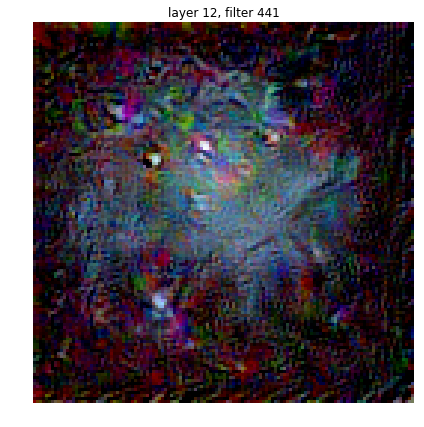

In [152]:
optimize_image(layer=12, filter_idx=441, input_image=ngc99)

## Try NGC 2713

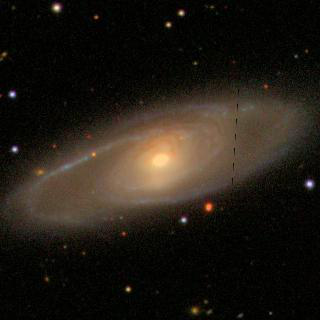

In [153]:
ngc2713 = Image.open(requests.get('https://skyserver.sdss.org/dr13/en/tools/places/images/ngc2713.jpg', stream=True).raw)
ngc2713

### Layer 7

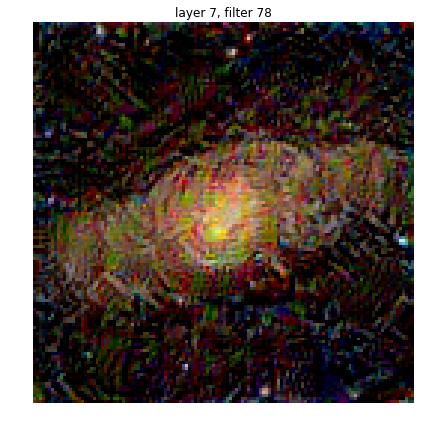

In [154]:
optimize_image(layer=7, filter_idx=78, input_image=ngc2713)

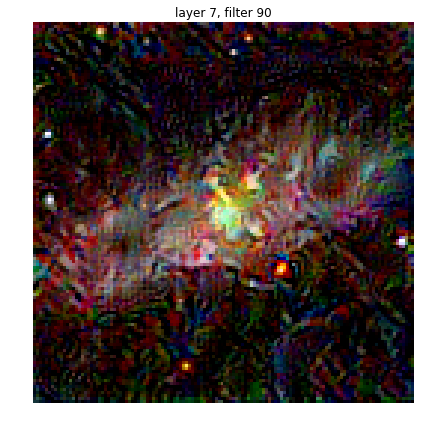

In [155]:
optimize_image(layer=7, filter_idx=90, input_image=ngc2713)

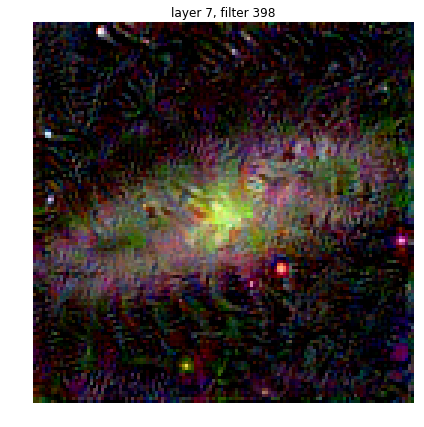

In [156]:
optimize_image(layer=7, filter_idx=398, input_image=ngc2713)

^ that one is cool

### Layer 4

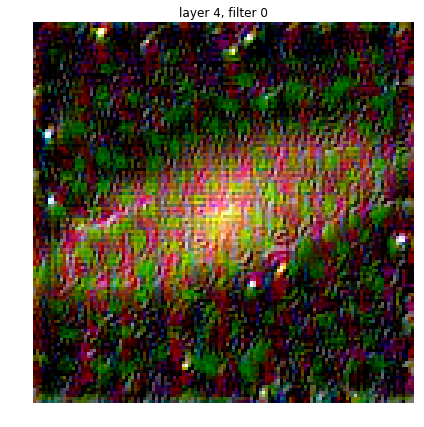

In [157]:
optimize_image(layer=4, filter_idx=0, input_image=ngc2713)

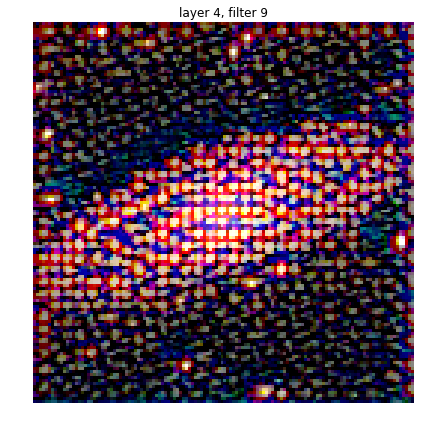

In [158]:
optimize_image(layer=4, filter_idx=9, input_image=ngc2713)

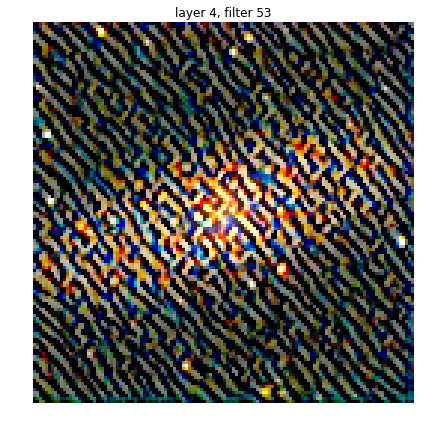

In [159]:
optimize_image(layer=4, filter_idx=53, input_image=ngc2713)

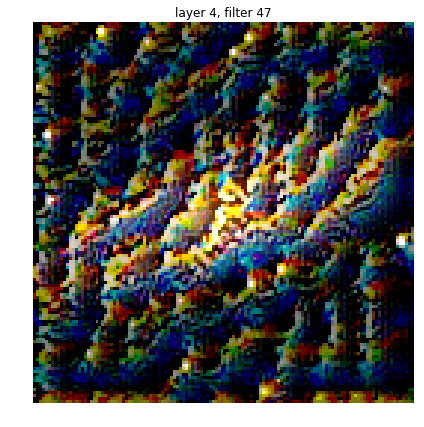

In [160]:
optimize_image(layer=4, filter_idx=47, input_image=ngc2713)

### Layer 12

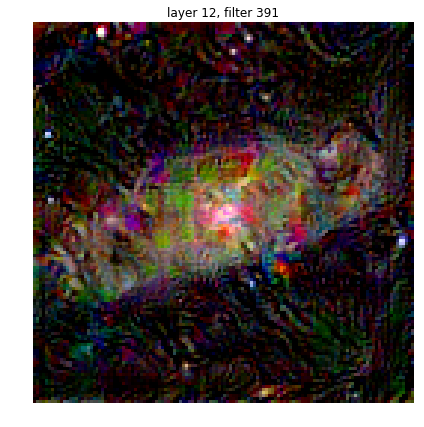

In [161]:
optimize_image(layer=12, filter_idx=391, input_image=ngc2713)

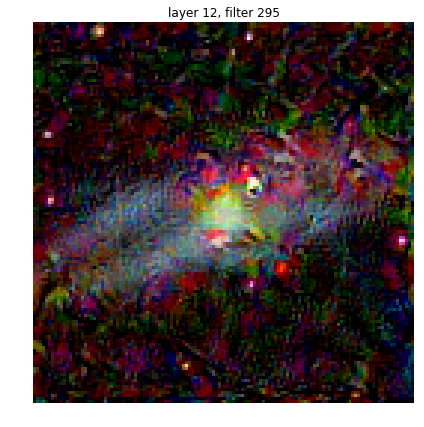

In [162]:
optimize_image(layer=12, filter_idx=295, input_image=ngc2713)

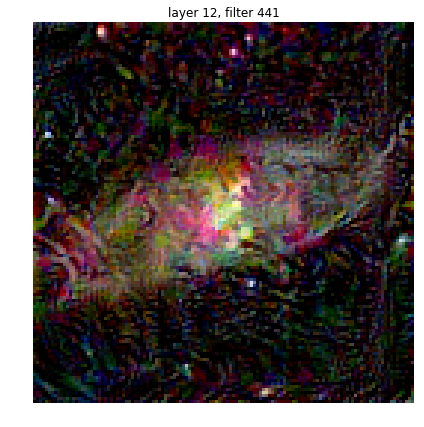

In [163]:
optimize_image(layer=12, filter_idx=441, input_image=ngc2713)

# Random initialization trained model

## Load data and model

In [4]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n, val_pct=0.2, seed=256)

In [5]:
arch = resnet34
sz = 128
bs = 128

# get data transformers and ClassifierData object (for regression)
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

n_batch = len(data.trn_y) // bs

# initialize pretrained network
learn = ConvLearner.pretrained(arch, data)
learn.crit = rmse

/home/john/anaconda3/envs/fastai-v0.7_torch-v0.4/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/john/anaconda3/envs/fastai-v0.7_torch-v0.4/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [6]:
learn.load('resnet34_rand-init_superconvergent-2')
learn.crit = rmse

In [11]:
model = learn.model

## Layer 7 (no pretrain)

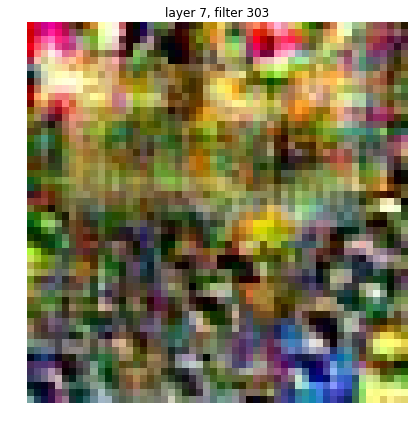

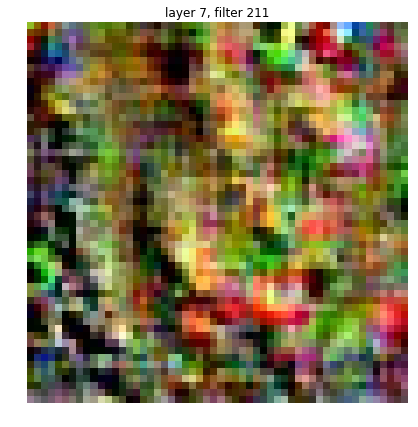

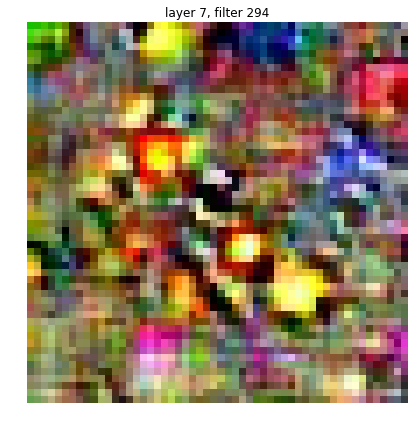

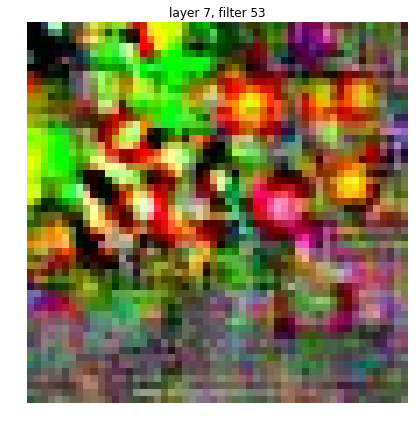

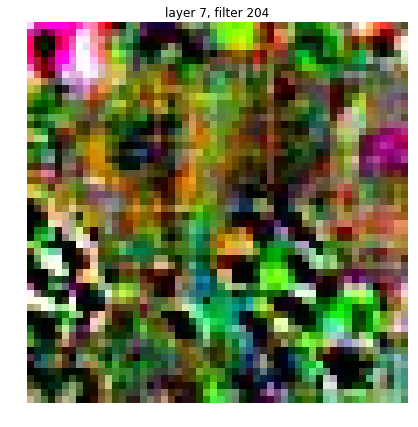

In [12]:
layer = 7

np.random.seed(1234)
for filter_idx in np.random.randint(512, size=5):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=4, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

## Layer 4 (no pretrain)

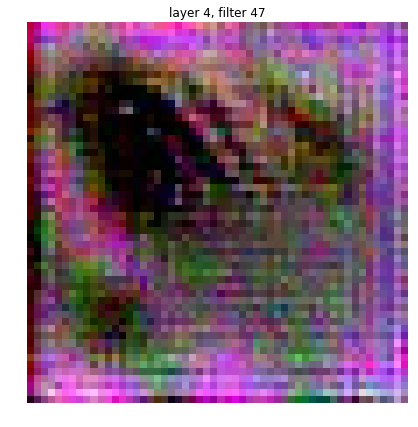

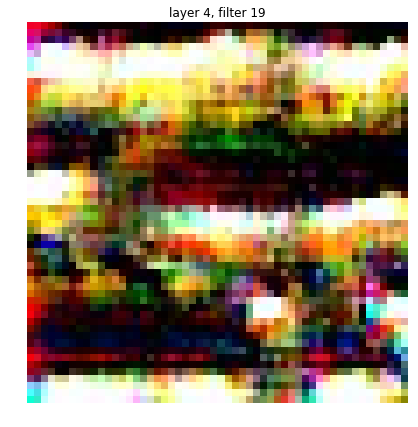

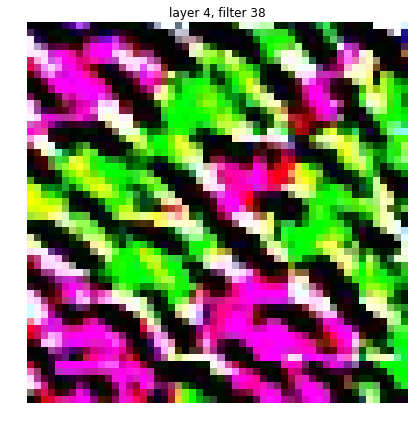

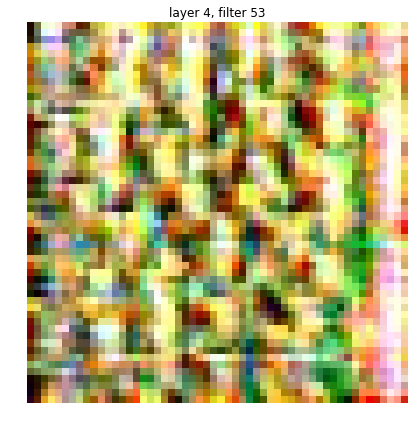

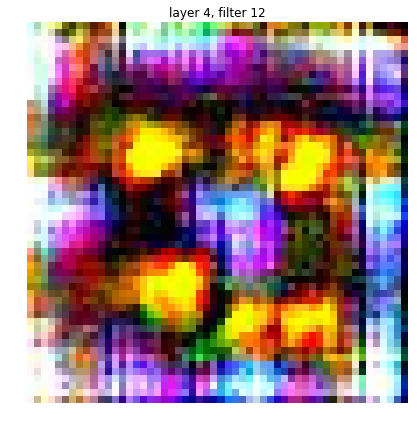

In [14]:
layer = 4

np.random.seed(1234)
for filter_idx in np.random.randint(64, size=5):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=4, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

## Layer 5 (no pretrain)

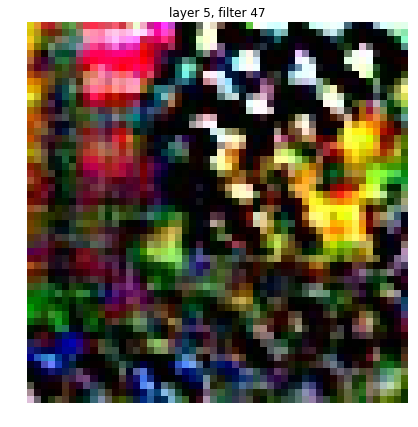

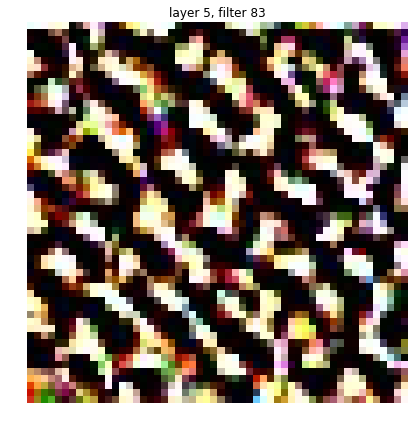

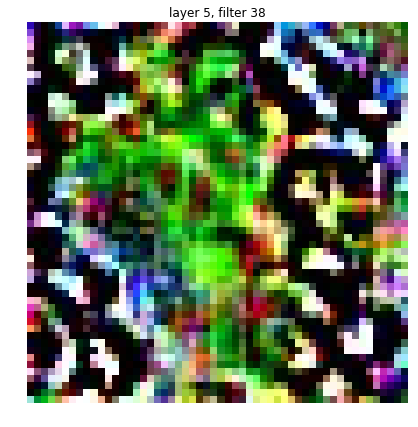

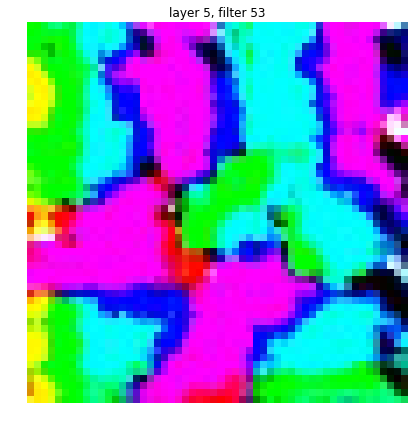

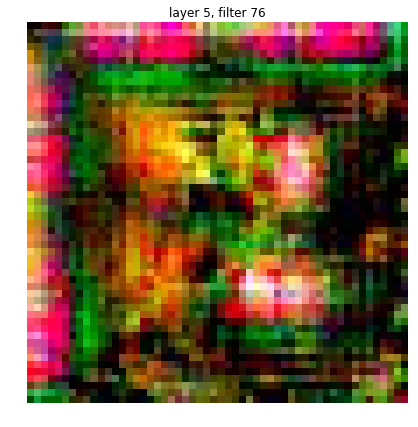

In [15]:
layer = 5

np.random.seed(1234)
for filter_idx in np.random.randint(128, size=5):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=4, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

## Layer 12

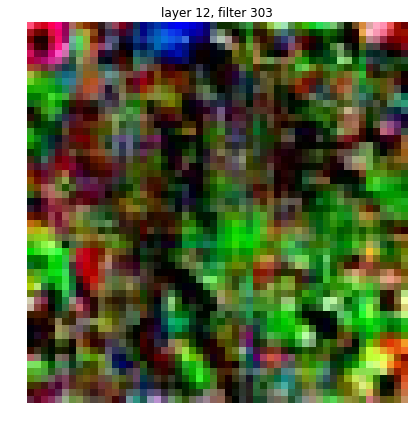

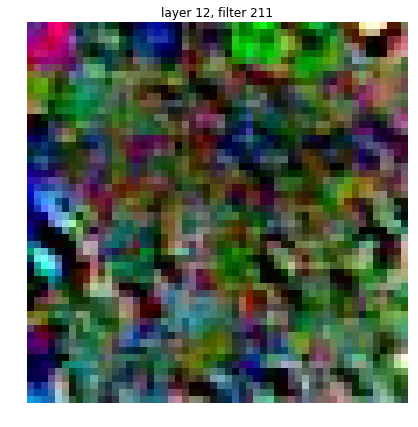

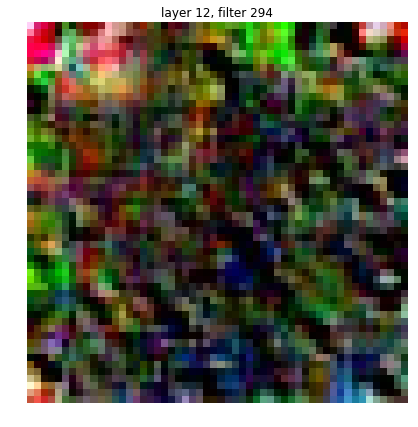

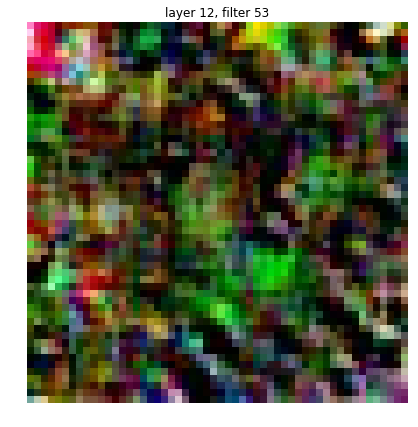

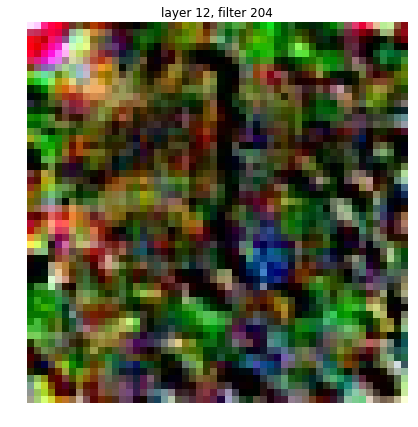

In [18]:
layer = 12

np.random.seed(1234)
for filter_idx in np.random.randint(512, size=5):
    FV = FilterVisualizer(model, tfms, size=32, upscaling_steps=4, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

## Test on NGC 99

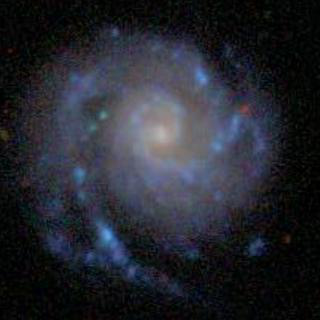

In [21]:
ngc99 = Image.open(requests.get('https://skyserver.sdss.org/dr13/en/tools/places/images/ngc99.jpg', stream=True).raw)
ngc99

### Layer 12 activations?

In [24]:
x, y = next(iter(data.val_dl))

layer = 12
layer_12_model = nn.Sequential(*children(model)[:layer+1])
layer_12_activations = layer_12_model(x)

top_10_acts = list(reversed(layer_12_activations.numpy().mean(axis=(0)).argsort()))[:10]
top_10_acts

[477, 280, 28, 436, 357, 52, 484, 478, 85, 53]

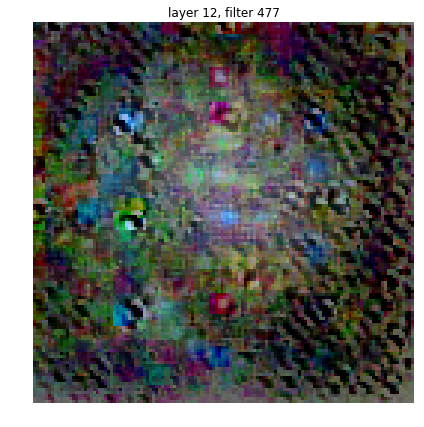

In [25]:
optimize_image(layer=12, filter_idx=477, input_image=ngc99)

### Layer 4 activations

In [31]:
layer = 4
layer_4_model = nn.Sequential(*children(model)[:layer+1])
layer_4_activations = layer_4_model(x)

list(reversed(layer_4_activations.numpy().mean(axis=(0, 2, 3)).argsort()))[:10]


[50, 52, 33, 32, 35, 24, 47, 44, 28, 61]

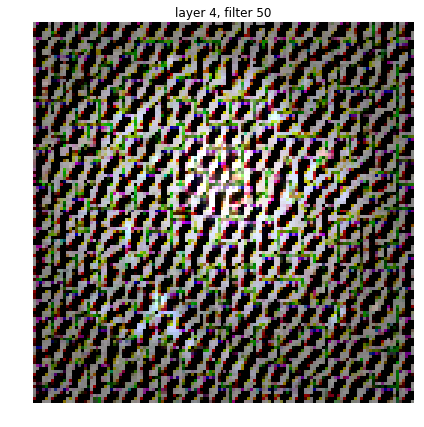

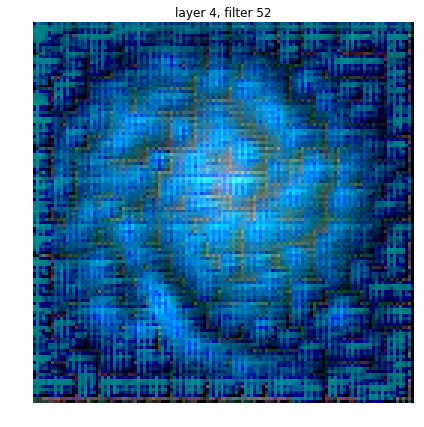

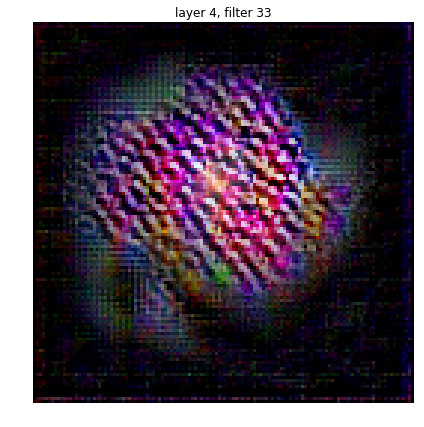

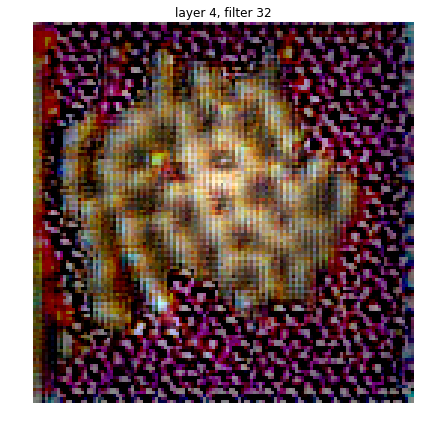

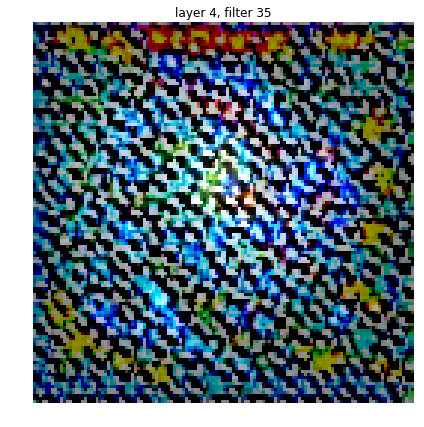

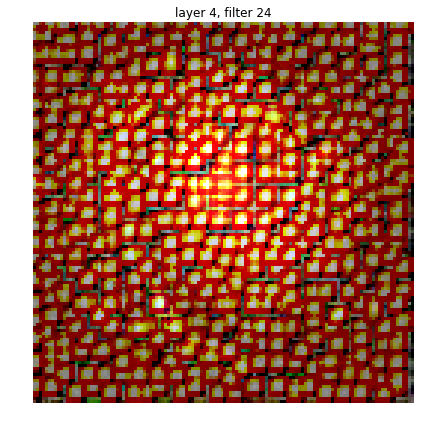

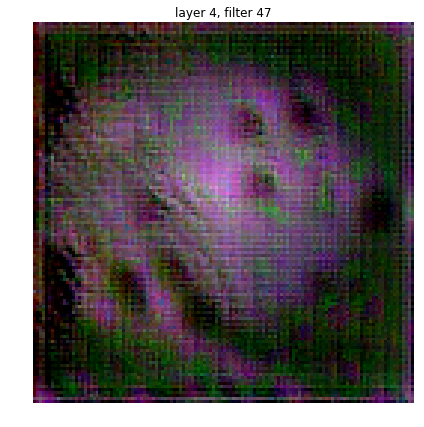

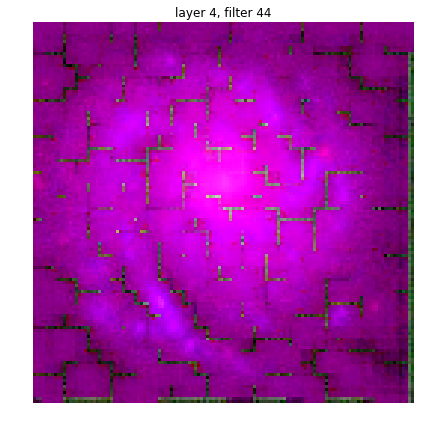

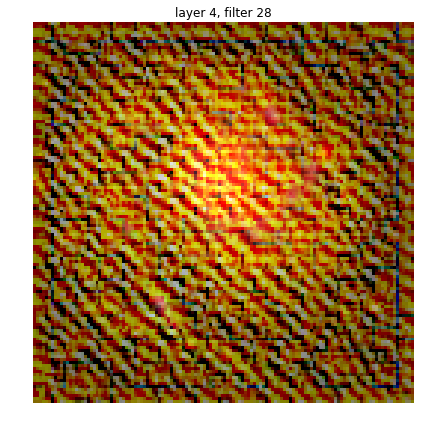

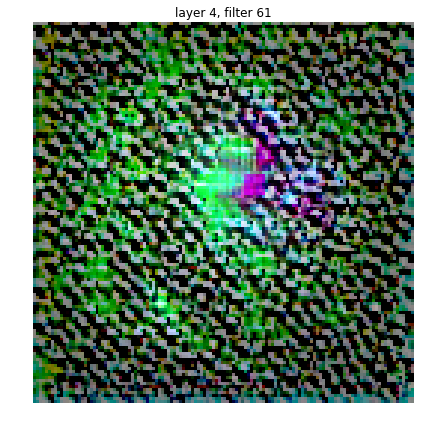

In [33]:
for filter_idx in list(reversed(layer_4_activations.numpy().mean(axis=(0, 2, 3)).argsort()))[:10]:
    optimize_image(layer=4, filter_idx=filter_idx, input_image=ngc99)

## Test on NGC 2713

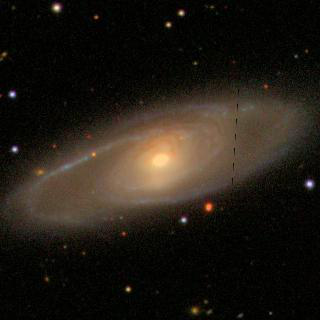

In [34]:
ngc2713 = Image.open(requests.get('https://skyserver.sdss.org/dr13/en/tools/places/images/ngc2713.jpg', stream=True).raw)
ngc2713

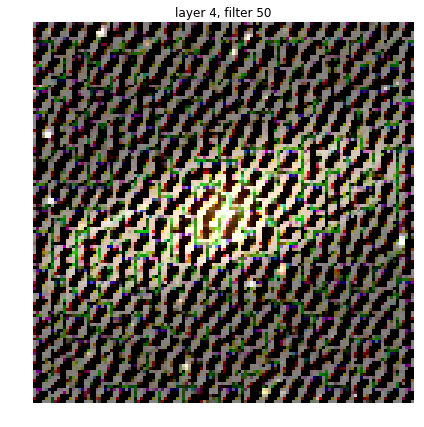

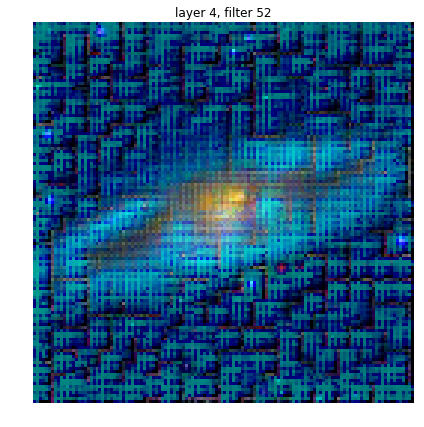

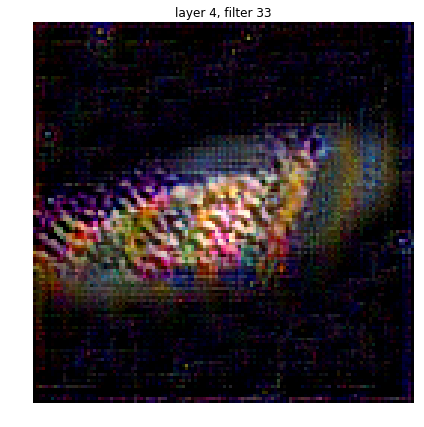

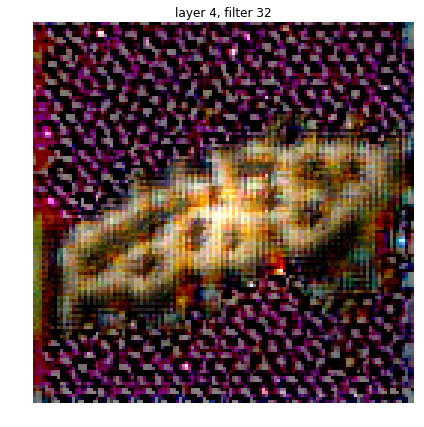

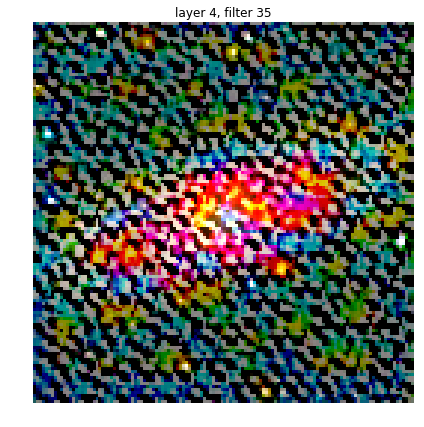

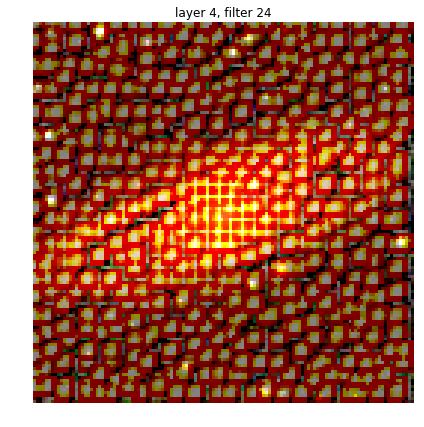

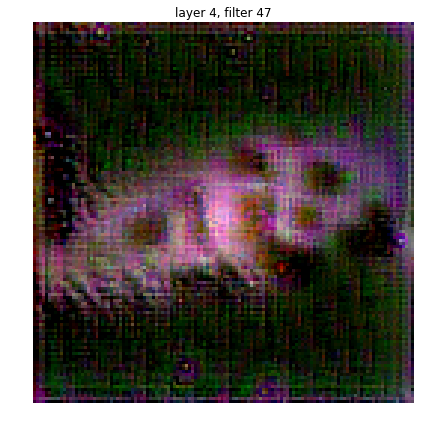

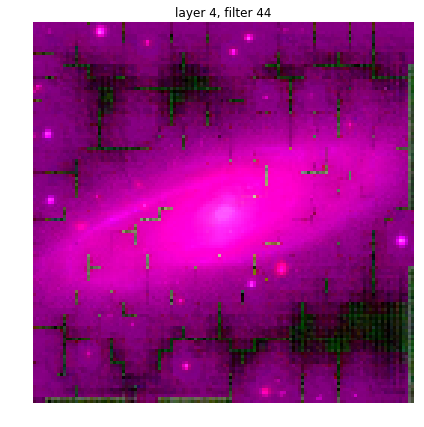

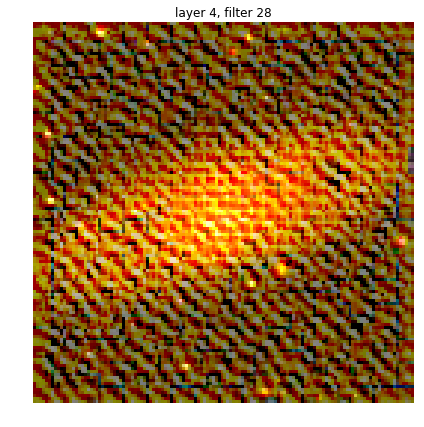

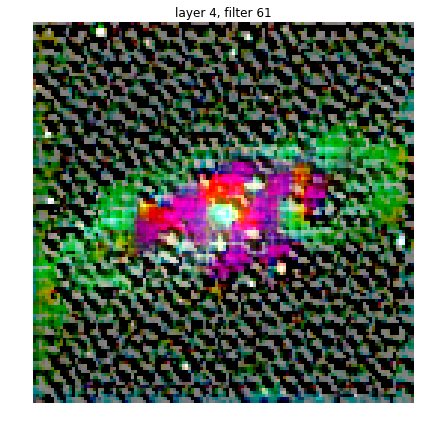

In [35]:
for filter_idx in list(reversed(layer_4_activations.numpy().mean(axis=(0, 2, 3)).argsort()))[:10]:
    optimize_image(layer=4, filter_idx=filter_idx, input_image=ngc2713)